In [216]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import safeopt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sps

import tikzplotlib






In [217]:
def global_reward(x1,x2,x3):
    "Each agent contributes to a different part of the global function"
    
    result =  np.sin(x1**3) + np.cos(x2**2) - np.sin(x3)
    
    return result


class Agent:
    def __init__(self,id,bounds,safe_point):
        self.bounds = [bounds]
        self.id = id
        self.safepoint = safe_point
        self.global_rewards = np.array([])
        self.local_rewards = np.array([])
        self.max_belief_g = np.array([[]])
        self.max_belief_l = np.array([[]])

        self.global_x0 = np.asarray([[self.safepoint]])
        self.global_y0 = np.asarray([[1]]) #predermined initial reward for all agents close to the actual

        self.kernel = GPy.kern.RBF(input_dim=1)
        self.gp = GPy.models.GPRegression(self.global_x0,self.global_y0, self.kernel, noise_var=0.05**2)
        self.parameter_set = safeopt.linearly_spaced_combinations(self.bounds, 100)

        self.global_opt = safeopt.SafeOpt(self.gp, self.parameter_set, -0.3,beta=10,threshold=0.2)

        self.local_x0 = np.asarray([[self.safepoint]])
        self.local_y0 = self.local_reward(self.safepoint)
        self.local_y0 = np.asarray([[self.local_y0]])
        print(f"Local Reward for agent {self.id} is {self.local_y0}")

        self.local_gp = GPy.models.GPRegression(self.local_x0,self.local_y0, self.kernel, noise_var=0.01**2)
        self.local_opt = safeopt.SafeOpt(self.local_gp, self.parameter_set,-0.3,beta=3,threshold=0.2)

    def local_reward(self,x):
        
        if self.id == 1:
            return np.sin(x**3)
        elif self.id == 2:
            return np.cos(x**2)
        elif self.id == 3:
            return -np.sin(x)
        
    def predict_local(self):

        x_next_l = self.local_opt.optimize()

        return x_next_l
    
    def predict_global(self):
            
        x_next_g = self.global_opt.optimize()
    
        return x_next_g
    
    def update_local(self,x_next,y_meas):
        self.max_belief_l = np.append(self.max_belief_l,self.local_opt.get_maximum()[1])
        
        self.local_rewards = np.append(self.local_rewards,y_meas)
        self.local_opt.add_new_data_point(x_next, y_meas)

    def update_global(self,x_next,y_meas):
        self.max_belief_g = np.append(self.max_belief_g,self.global_opt.get_maximum()[1])
        
        self.global_rewards = np.append(self.global_rewards,y_meas)
        self.global_opt.add_new_data_point(x_next, y_meas)


    def plot_gp_local(self):
        """
        Plot the local reward belief
        """
        if self.id == 1:
            self.local_opt.plot(1000)
            plt.plot(self.parameter_set, self.local_reward(self.parameter_set),color="C2", alpha=0.3,label='sin(x1^3')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')

        if self.id == 2:
            self.local_opt.plot(1000)
            plt.plot(self.parameter_set, self.local_reward(self.parameter_set),color="C2", alpha=0.3, label='cos(x2^2)')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')
        if self.id == 3:
            self.local_opt.plot(1000)
            plt.plot(self.parameter_set, self.local_reward(self.parameter_set),color="C2", alpha=0.3, label='sin(x3)')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')

        plt.title(f"Agent {self.id} Local Reward Estimation")
        plt.show()
        
    def plot_gp_global(self):
        """
        Plot the global reward belief
        """
        if self.id == 1:
            self.global_opt.plot(1000)
            plt.plot(self.parameter_set, global_reward(self.parameter_set,self.parameter_set,self.parameter_set),color="r", alpha=0.8, label='sin(x1^3) + cos(x2^2) - sin(x3)')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')
        if self.id == 2:
            self.global_opt.plot(1000)
            plt.plot(self.parameter_set, global_reward(self.parameter_set,self.parameter_set,self.parameter_set),color="r", alpha=0.8, label='sin(x1^3) + cos(x2^2) - sin(x3)')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')
        if self.id == 3:
            self.global_opt.plot(1000)
            plt.plot(self.parameter_set, global_reward(self.parameter_set,self.parameter_set,self.parameter_set),color="r", alpha=0.8, label='sin(x1^3) + cos(x2^2) - sin(x3)')
            plt.legend()
            # plt.annotate(f"Correlation: {corr}", xy=(0.5, 0.5), xycoords='axes fraction')
            
        plt.title(f"Agent {self.id} Global Reward Estimation")
        plt.show()


  
    

In [218]:

agent1 = Agent(1,(-1.3,1.5),0)
agent2 = Agent(2,(-1.3,1.5),0.1)
agent3 = Agent(3,(-1.3,1.5),-0.1)

agents = [agent1,agent2,agent3]


Local Reward for agent 1 is [[0.]]
Local Reward for agent 2 is [[0.99995]]
Local Reward for agent 3 is [[0.09983342]]


Update all Local rewards of agents


In [219]:
iterations = 50

In [220]:
agent1_predictions = np.array([])

In [221]:
for _ in range(iterations):
    x_next_1 = agent1.predict_local()
    agent1_predictions = np.append(agent1_predictions,x_next_1)
    y_meas_1 = agent1.local_reward(x_next_1)
    agent1.update_local(x_next_1,y_meas_1)

    x_next_2 = agent2.predict_local()
    y_meas_2 = agent2.local_reward(x_next_2)
    agent2.update_local(x_next_2,y_meas_2)

    x_next_3 = agent3.predict_local()
    y_meas_3 = agent3.local_reward(x_next_3)
    agent3.update_local(x_next_3,y_meas_3)


Update All Global rewards of agents

In [222]:
for _ in range(iterations):
    x_pred_1 = agent1.predict_global()
    x_pred_2 = agent2.predict_global()
    x_pred_3 = agent3.predict_global()

    y_meas = global_reward(x_pred_1,x_pred_2,x_pred_3)

    #update global belief of all agents
    agent1.update_global(x_pred_1,y_meas)
    agent2.update_global(x_pred_2,y_meas)
    agent3.update_global(x_pred_3,y_meas)


In [223]:
print("reward is ",y_meas)

reward is  [2.54498298]


In [224]:
def correlation(x1,x2):
    return sps.stats.pearsonr(x1,x2)[0]


Correlation between **estimated local** and **true global reward** of **Agent 1**

In [225]:
# x = np.linspace(-1.3,1.5,100)


# x.squeeze()
# gr_true= global_reward(x,x,x)
# lr_est = agent1.local_rewards

# lr2_est = agent2.local_rewards
# lr3_est = agent3.local_rewards

# sections_true_global = find_continuous_positive_sections(x,gr_true,-0.3)

# sections_est_local = find_continuous_positive_sections(x,lr_est,-0.3)
# sections_est_local2 = find_continuous_positive_sections(x,lr2_est,-0.3)
# sections_est_local3 = find_continuous_positive_sections(x,lr3_est,-0.3)


# generate_correlated_plot(x,gr_true,x,lr_est,"Gp: sin(x^3)", sections_true_global,sections_est_local)
# generate_correlated_plot(x,gr_true,x,lr2_est,"Gp: cos(x^2)", sections_true_global,sections_est_local2)
# generate_correlated_plot(x,gr_true,x,lr3_est,"Gp: -sin(x)", sections_true_global,sections_est_local3)

# plt.plot(x,np.sin(lr_est**3),label="sin(x^3)")

In [226]:
print("----Local-Global Estimation----\n")
lg_1 = sps.stats.pearsonr(agent1.local_rewards,agent1.global_rewards)[0]
lg_2 = sps.stats.pearsonr(agent2.local_rewards,agent2.global_rewards)[0]
lg_3 = sps.stats.pearsonr(agent3.local_rewards,agent3.global_rewards)[0]
print(f"Agent 1: {lg_1}, Agent 2: {lg_2}, Agent 3: {lg_3} \n")

ll_13=sps.stats.pearsonr(agent1.local_rewards,agent3.local_rewards)[0]
ll_12=sps.stats.pearsonr(agent1.local_rewards,agent2.local_rewards)[0]
ll_23=sps.stats.pearsonr(agent2.local_rewards,agent3.local_rewards)[0]
print(f"Local-Local Agent 1 - Agent 3: {ll_13}, Agent 1 - Agent 2: {ll_12}, Agent 2 - Agent 3: {ll_23}")

lg_m_1 = sps.stats.pearsonr(agent1.max_belief_g,agent1.global_rewards)[0]
lg_m_2 = sps.stats.pearsonr(agent2.max_belief_g,agent2.global_rewards)[0]
lg_m_3 = sps.stats.pearsonr(agent3.max_belief_g,agent3.global_rewards)[0]
print(f"Max Belief-Global Agent 1: {lg_m_1}, Agent 2: {lg_m_2}, Agent 3: {lg_m_3}")



----Local-Global Estimation----

Agent 1: 0.49174000995702916, Agent 2: 0.30746036065812105, Agent 3: 0.29749471393265264 

Local-Local Agent 1 - Agent 3: 0.45149816585294356, Agent 1 - Agent 2: 0.8450313718100451, Agent 2 - Agent 3: 0.061594383092766665
Max Belief-Global Agent 1: 0.5200472378017714, Agent 2: 0.5140108135041608, Agent 3: 0.5402812818765677


Gaussian Process Regression

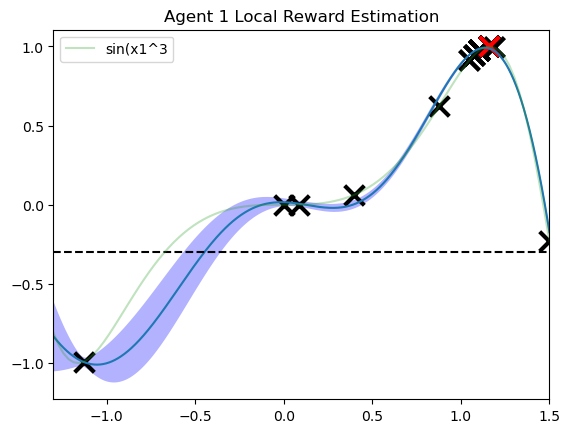

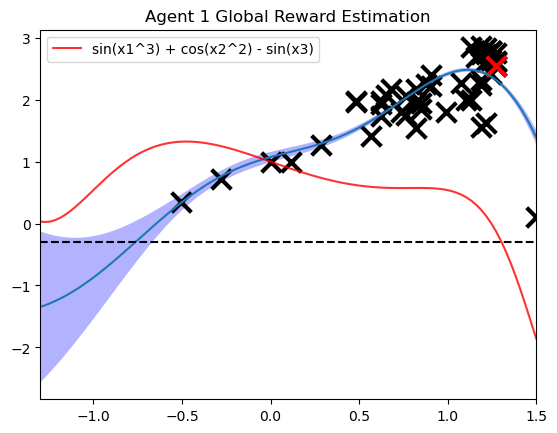

<Figure size 640x480 with 0 Axes>

In [227]:
agent1.plot_gp_local()
agent1.plot_gp_global()
tikzplotlib.save("agent1.tex")
# agent2.plot_gp_local()
# agent2.plot_gp_global()


# agent3.plot_gp_local()
# agent3.plot_gp_global()

In [228]:
print(agent1.max_belief_g)


[0.49802666 0.64594493 0.81548707 1.23598505 1.77989304 1.78225371
 1.77692027 1.75754282 1.84699279 1.91293391 1.92510263 1.94026773
 1.9297569  1.96198412 1.92630907 1.95041421 1.97683148 1.93523946
 2.02918828 2.00141633 2.07017121 2.09454824 2.10186572 2.04617411
 2.10592286 2.12143703 2.1417564  2.12968756 2.16932269 2.15820396
 2.19222251 2.22667431 2.22707186 2.249531   2.23243627 2.25806241
 2.26815919 2.29145202 2.29341919 2.30862461 2.29950313 2.31806913
 2.33438713 2.34509972 2.35285759 2.3549861  2.36193339 2.36124506
 2.37012907 2.37490335]
